In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns 

from torchvision import transforms
from torch.utils.data import DataLoader 
from dataset import CustomDataset 

import torch
import torch.nn as nn

import os
import numpy as np 

import torchvision.models as models 
from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm


os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [24]:
test_dir = 'data/test'

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    # transforms.Resize((299,299), antialias=True),
    transforms.Grayscale(num_output_channels=3),
    # transforms.Normalize((0.5), (0.5)),
    
])

ts_batch = 100

test_dataset = CustomDataset(root_dir= test_dir, transform= test_transform) 
test_loader = DataLoader(dataset = test_dataset, batch_size= ts_batch, shuffle= False)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}") 

MODEL_PATH = './metric'

## vgg16
# model = models.vgg16()
# model.classifier[-1] = nn.Linear(4096, 1)
# checkpoint = torch.load(os.path.join(MODEL_PATH, 'vgg16.pt'))

## Mobile net
# model = models.mobilenet_v2()
# model.classifier[-1] = nn.Linear(1280, 1) #mobilenet_v2 
# checkpoint = torch.load(os.path.join(MODEL_PATH, 'mobilenet.pt'))

## resnet18
# model = models.resnet18()
# model.fc = nn.Linear(512, 1) #mobilenet_v2 
# checkpoint = torch.load(os.path.join(MODEL_PATH, 'resnet18.pt'))


## efficentent 
model = models.efficientnet_v2_m()
model.classifier[-1] = nn.Linear(1280, 1) #EfficientNet_V2_M
checkpoint = torch.load(os.path.join(MODEL_PATH, 'efficient.pt'))

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device) 

epoch = checkpoint['epoch']
epochs = checkpoint['epochs']
lr = checkpoint['learning_rate']

loss = checkpoint['loss']


device : cuda


In [26]:
metrics = checkpoint['metric']

t_loss_li = np.array(torch.tensor(checkpoint['t_loss']).detach().cpu())
v_loss_li = np.array(torch.tensor(checkpoint['v_loss']).detach().cpu())
train_acc = np.array(torch.tensor(metrics['train_accuracy']).detach().cpu())
train_f1 = np.array(torch.tensor(metrics['train_f1']).detach().cpu())
train_recall = np.array(torch.tensor(metrics['train_sensitivity']).detach().cpu())
valid_acc = np.array(torch.tensor(metrics['valid_accuracy']).detach().cpu())
valid_f1 = np.array(torch.tensor(metrics['valid_f1']).detach().cpu())
valid_recall = np.array(torch.tensor(metrics['valid_sensitivity']).detach().cpu())


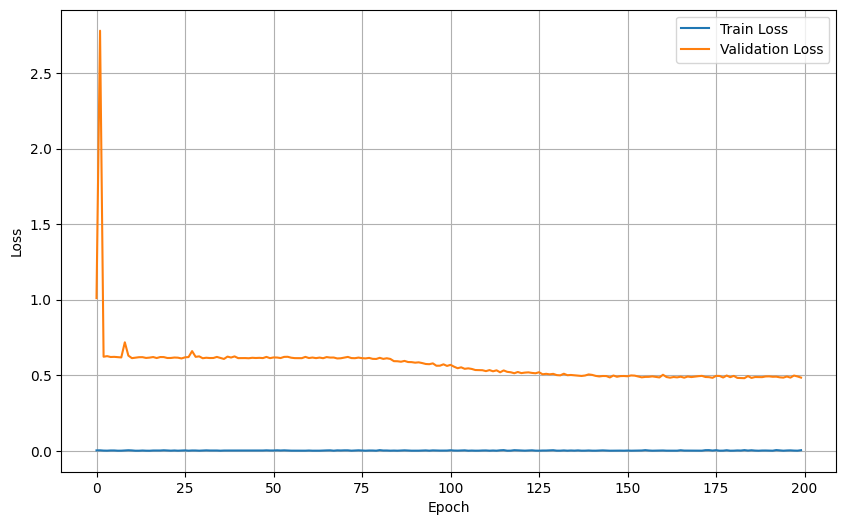

In [27]:
# Loss 
plt.figure(figsize=(10, 6))
plt.plot(t_loss_li, label='Train Loss')
plt.plot(v_loss_li, label='Validation Loss')
# plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

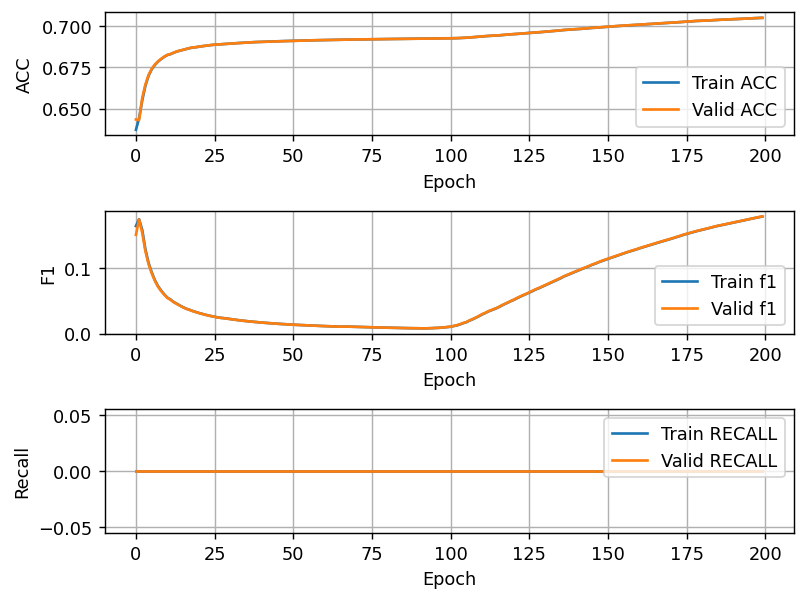

In [28]:
plt.figure(dpi = 128)
plt.subplot(311)
plt.plot(train_acc, label = 'Train ACC')
plt.plot(valid_acc, label = 'Valid ACC')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.legend()
plt.grid()

plt.subplot(312)
plt.plot(train_f1, label = 'Train f1')
plt.plot(valid_f1, label = 'Valid f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.grid()

plt.subplot(313)
plt.plot(train_recall, label = 'Train RECALL')
plt.plot(valid_recall, label = 'Valid RECALL')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.tight_layout()
plt.grid()

In [29]:
label_data = np.array([])
output_data = np.array([])
model.eval()
for _, (inputs, labels) in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = F.sigmoid(model(inputs)).squeeze(dim = 1)
        
        label_data = np.concatenate((label_data, np.array(labels.detach().cpu())))
        output_data = np.concatenate((output_data, np.array((outputs>0.5).int().detach().cpu())))
        
        

3it [00:04,  1.44s/it]


In [30]:
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, roc_curve, roc_auc_score, auc, confusion_matrix
print(f"Accuracy : {accuracy_score(label_data, output_data):.3f}")
print(f"Precision : {precision_score(label_data, output_data):.3f}")
print(f"Sensitivity : {recall_score(label_data, output_data):.3f}")
print(f"F1 Score : {f1_score(label_data, output_data):.3f}")
print(f"ROC_AUC_Score : {roc_auc_score(label_data, output_data):.3f}")

Accuracy : 0.755
Precision : 0.694
Sensitivity : 0.370
F1 Score : 0.482
ROC_AUC_Score : 0.648


In [31]:
from sklearn.metrics import classification_report
print(classification_report(label_data, output_data))

              precision    recall  f1-score   support

         0.0       0.77      0.93      0.84       206
         1.0       0.69      0.37      0.48        92

    accuracy                           0.76       298
   macro avg       0.73      0.65      0.66       298
weighted avg       0.74      0.76      0.73       298



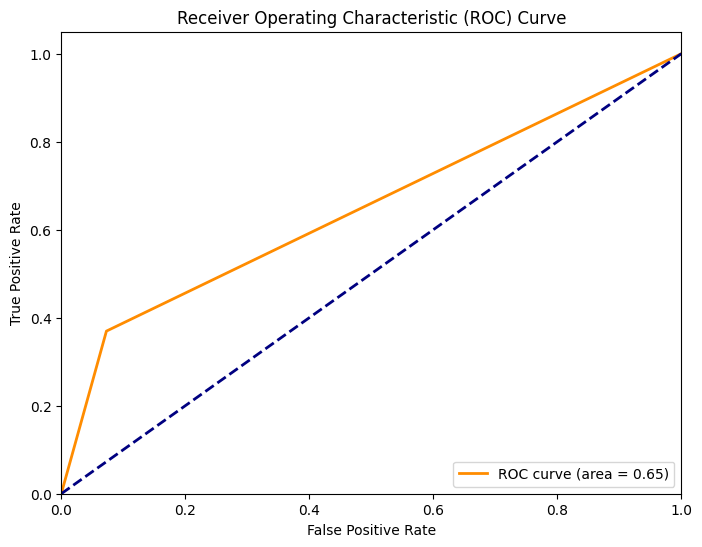

In [32]:
fpr, tpr, thresholds = roc_curve(label_data, output_data)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC Curve 플로팅
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

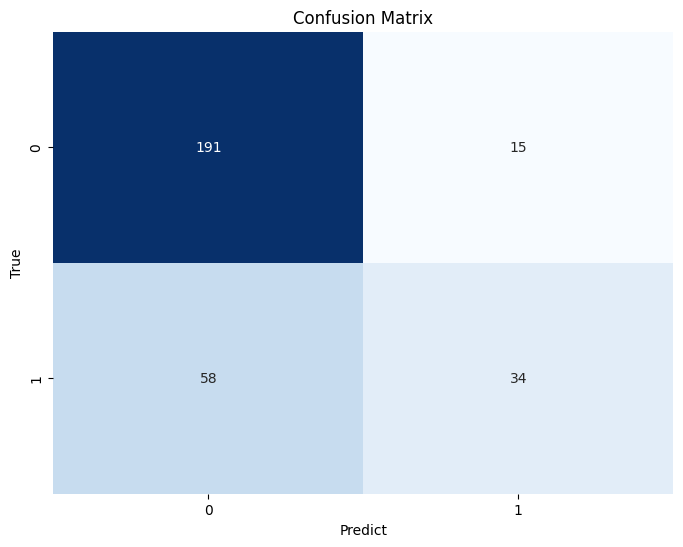

In [33]:
cm = confusion_matrix(label_data, output_data)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # fmt='d'로 정수 표현
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()